In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def party2colour(party):
    if party.startswith('Lab'):
        return 'red'
    if party.startswith('Grn'):
        return 'green'
    if party.startswith('Ind'):
        return 'grey'
    if party.startswith('LDem'):
        return 'yellow'
    if party.startswith('Con'):
        return 'blue'
    if party.startswith('UKIP'):
        return 'purple'

def clean_cols(df):
    df.columns = df.columns.str.lstrip(' ').str.rstrip(' ')
    return df

def get_insolvencies_by_la():
    df = pd.ExcelFile('data/Individual_insolvencies_by_location_2000-17_tables/Total insolvencies 2000_2017.xlsx')
    df = df.parse('Local Authorities')
    df.iloc[1] = df.iloc[1].ffill()
    df.columns = df.iloc[1].fillna('').astype(str) + ' '+ df.iloc[2].fillna('').astype(str)
    df = clean_cols(df)
    return df

def get_election_data():
    df = pd.read_csv('data/LE2018 ward-by-ward results_ London only [Britain Elects] - Totals.csv')
    df.iloc[0,0] = ''
    df.columns = df.iloc[1].fillna('') + ' ' + df.iloc[0].ffill()
    df = clean_cols(df)
    df = df.drop([0,1])
    return df

In [2]:
df_insolv = get_insolvencies_by_la()

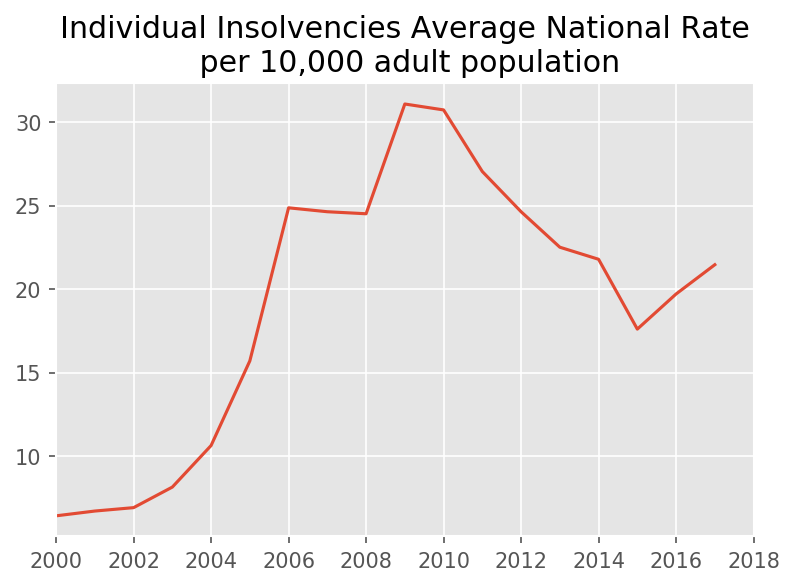

In [12]:
df_insolv_agged = df_insolv.drop([0,1,2])
df_insolv_agged = df_insolv_agged.drop(['Local Authorities'],axis=1)
df_insolv_agged = df_insolv_agged.drop(['Codes'],axis=1)

s = df_insolv_agged.mean()
per_10k = s[s.index.str.contains('Rate per 10,000 adult population')]
per_10k.index = per_10k.index.to_series().apply(lambda x : float(x.split(' ')[0]))

plt.figure(dpi=150)
plt.title('Individual Insolvencies Average National Rate\n per 10,000 adult population')
per_10k.plot()
plt.xlim(2000,2018)
plt.savefig('images/national_insolvencies_rate.png')
plt.show()

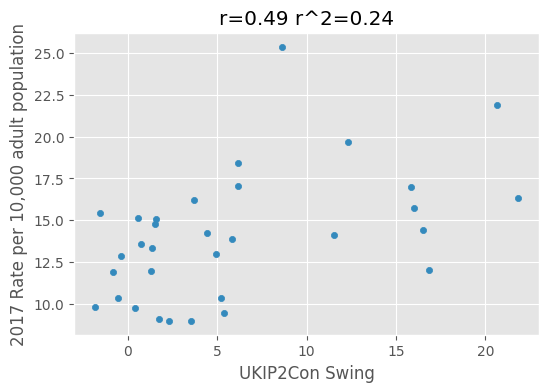

In [9]:
df_elec = get_election_data()
party_a = 'UKIP'
party_b = 'Con'
df_elec[f'{party_a}2{party_b} Swing'] = (df_elec[f'{party_b} PCT +/-'].astype(float) - df_elec[f'{party_a} PCT +/-'].astype(float))/2

x_col = f'{party_a}2{party_b} Swing'
y_col = '2017 Rate per 10,000 adult population'

df_elect_lab = df_elec[['Authority',x_col]].rename(columns={'Authority' : 'Local Authorities'})
df_elect_lab['Local Authorities'] = df_elect_lab['Local Authorities'].str.replace('&','and')
df_elect_lab[x_col] = df_elect_lab[x_col].astype(float)
df_elect_lab = df_elect_lab.groupby('Local Authorities').mean().reset_index()

df_insolv_2016_nc = df_insolv.drop([0,1,2])[['Local Authorities',y_col]]

df_merged = df_elect_lab.merge(df_insolv_2016_nc,on='Local Authorities')
df_merged[[x_col, y_col]] = df_merged[[x_col, y_col]].astype(float)

fig,ax = plt.subplots(dpi=100)
df_merged.plot(ax=ax,kind='scatter',x=x_col,y=y_col)

r = df_merged.corr().iloc[0][y_col]
ax.set_title(f'r={round(r,2)} r^2={round(r**2,2)}')
plt.savefig('UKIP2Con.png')
plt.show()

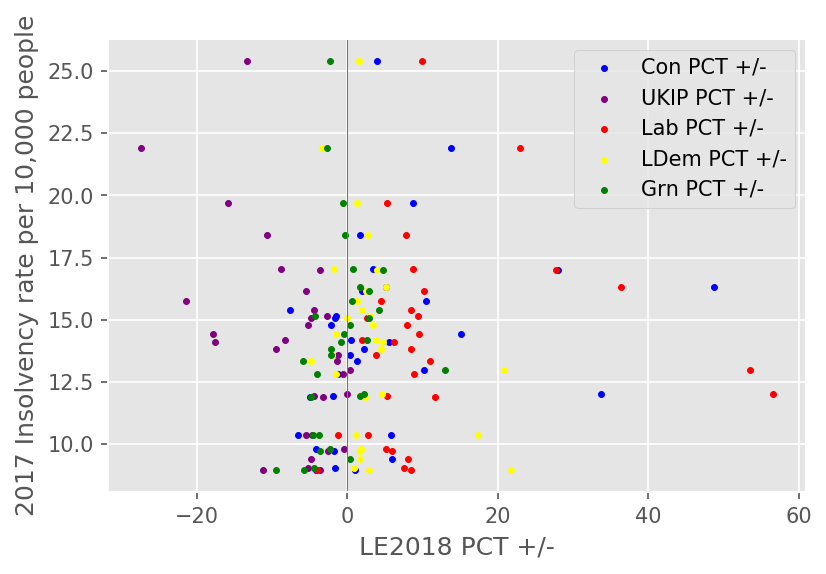

In [10]:
parties = ['Con','UKIP','Lab','LDem','Grn']
x_cols = [f'{party} PCT +/-' for party in parties]

df_elect_lab = df_elec[['Authority'] + x_cols].rename(columns={'Authority' : 'Local Authorities'})
df_elect_lab['Local Authorities'] = df_elect_lab['Local Authorities'].str.replace('&','and')

df_elect_lab[x_cols] = df_elect_lab[x_cols].astype(float)
df_elect_lab = df_elect_lab.groupby('Local Authorities').mean().reset_index()

df_insolv_2016_nc = df_insolv.drop([0,1,2])[['Local Authorities',y_col]]

df_merged = df_elect_lab.merge(df_insolv_2016_nc,on='Local Authorities')
df_merged[x_cols + [y_col]] = df_merged[x_cols + [y_col]].astype(float)

fig,ax = plt.subplots(dpi=150)
for x_col in x_cols:
    df_merged.plot(ax=ax,kind='scatter',x=x_col,y=y_col,label=x_col,c=party2colour(x_col),s=8)
ax.set_ylabel('2017 Insolvency rate per 10,000 people')
ax.set_xlabel('LE2018 PCT +/-')
plt.axvline(0,linewidth=0.5)
plt.savefig('all_parties_insolvencies.png')
plt.show()

In [11]:
corr = df_merged.corr()
corr['r'] = corr['2017 Rate per 10,000 adult population']
corr['r^2'] = corr['2017 Rate per 10,000 adult population']**2
corr = corr[['r','r^2']].sort_values(by='r')
print(corr[corr.r != 1.00])

                     r       r^2
UKIP PCT +/- -0.486734  0.236910
LDem PCT +/- -0.299321  0.089593
Lab PCT +/-   0.137356  0.018867
Con PCT +/-   0.268314  0.071992
Grn PCT +/-   0.270829  0.073348


In [29]:
df_merged

,Local Authorities,Con PCT +/-,UKIP PCT +/-,Lab PCT +/-,LDem PCT +/-,Grn PCT +/-,"2017 Rate per 10,000 adult population"
0,Barking and Dagenham,13.800000,-27.458824,22.958824,-3.311765,-2.723529,21.918253
1,Barnet,5.742857,-4.666667,2.795238,1.161905,-4.566667,10.361086
2,Bexley,48.782353,5.164706,36.341176,5.170588,1.629412,16.304004
3,Brent,1.290000,-1.405000,10.930000,-4.905000,-5.880000,13.357770
4,Bromley,5.468182,-17.604545,6.163636,4.781818,-0.822727,14.098296
5,Camden,-1.777778,-2.616667,5.955556,1.644444,-3.688889,9.745920
6,Croydon,27.989286,-3.692857,27.760714,3.971429,4.792857,16.996366
7,Ealing,-1.860870,-4.447826,5.239130,1.900000,1.686957,11.960805
8,Enfield,2.147619,-9.552381,8.423810,4.457143,-2.119048,13.843393
9,Greenwich,3.947059,-13.329412,9.911765,1.535294,-2.323529,25.397624


In [47]:
# import statsmodels.api as sm

# df_merged['random'] = 0
# df_merged['random'] = np.random.uniform(size=df_merged['random'].shape)

# for x_col in ['random']:
#     Y = df_merged['2017 Rate per 10,000 adult population']
#     X = df_merged[x_col]
#     X = sm.add_constant(X)

#     model = sm.OLS(Y,X)
#     results = model.fit()
#     print(x_col)
#     print(results.t_test([1, 0]))
#     print(results.f_test(pd.np.identity(2)))

random
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            15.3203      1.703      8.994      0.000      11.842      18.799
<F test: F=array([[213.61840326]]), p=1.7976331905475355e-18, df_denom=30, df_num=2>


In [14]:
df_elect_lab.sort_values(by='UKIP PCT +/-')

,Local Authorities,Con PCT +/-,UKIP PCT +/-,Lab PCT +/-,LDem PCT +/-,Grn PCT +/-
0,Barking and Dagenham,13.800000,-27.458824,22.958824,-3.311765,-2.723529
14,Havering,10.483333,-21.516667,4.505556,1.261111,0.550000
15,Hillingdon,15.122727,-17.931818,9.477273,-1.527273,-0.427273
4,Bromley,5.468182,-17.604545,6.163636,4.781818,-0.822727
27,Sutton,8.755556,-15.844444,5.233333,1.311111,-0.616667
9,Greenwich,3.947059,-13.329412,9.911765,1.535294,-2.323529
19,Kingston upon Thames,-4.125000,-11.231250,-4.062500,21.806250,-5.775000
16,Hounslow,1.630000,-10.705000,7.730000,2.745000,-0.320000
8,Enfield,2.147619,-9.552381,8.423810,4.457143,-2.119048
29,Waltham Forest,3.460000,-8.825000,8.695000,-1.815000,0.810000
